## Task 1: Disentangled VAE Model

Paper - https://arxiv.org/abs/1802.04942
Github - https://github.com/rtqichen/beta-tcvae

- I started on this task by going through the research paper "Isolating Sources of Disentanglement in VAEs"
- In understood in TCVAE, a total correlation term is added to the VAE objective function. 
- The total correlation term measures the mutual information between the latent variables, aiming to encourage independence or low dependence among them. The aim is to enhance the disentanglement and independence of the learned latent variables.
 

## Code to train TCVAE model on Celeba dataset

In [1]:
import os
import time
import math
# import pandas as pd
import numpy as np
from numbers import Number
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import visdom
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil

import lib.dist as dist
import lib.utils as utils
from lib.flows import FactorialNormalizingFlow

from elbo_decomposition import elbo_decomposition
from plot_latent_vs_true import plot_vs_gt_shapes, plot_vs_gt_faces
from vae_quant import VAE


### Built directories for Celeba dataset depending on the attribute - Bald,Oval_Face,Male,Mustache

In [2]:
# att=pd.read_csv('/home/desai.ven/TCVAE/list_attr_celeba.csv')

In [3]:
# att.columns

In [4]:
# att=att[["image_id","Bald","Oval_Face","Male","Mustache"]]

In [5]:
# for i, (_,row) in enumerate(att.iterrows()):
#     if row["Bald"]==1:
#         shutil.copyfile("/home/desai.ven/TCVAE/img_align_celeba/"+row["image_id"], "/home/desai.ven/TCVAE/celeba_att/Bald/"+row["image_id"] )
#     if row["Oval_Face"]==1:
#         shutil.copyfile("/home/desai.ven/TCVAE/img_align_celeba/"+row["image_id"], "/home/desai.ven/TCVAE/celeba_att/Oval_Face/"+row["image_id"] )
#     if row["Male"]==1:
#         shutil.copyfile("/home/desai.ven/TCVAE/img_align_celeba/"+row["image_id"], "/home/desai.ven/TCVAE/celeba_att/Male/"+row["image_id"] )
#     if row["Mustache"]==1:
#         shutil.copyfile("/home/desai.ven/TCVAE/img_align_celeba/"+row["image_id"], "/home/desai.ven/TCVAE/celeba_att/Mustache/"+row["image_id"] )

### Decided to train the images having Bald attributes

In [6]:
image_size = 64
pix_mean = [0.5, 0.5, 0.5]
pix_std = [0.5, 0.5, 0.5]

celeba_dataset = datasets.ImageFolder(
    root='/home/desai.ven/TCVAE/celeba_att/Bald',
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(pix_mean, pix_std),
    ]))

In [7]:
batch_size=32
num_worksers=4
kwargs = {'num_workers': 4, 'pin_memory': True}

In [8]:
train_loader=torch.utils.data.DataLoader(
    celeba_dataset,
    batch_size=32,
    shuffle=True,
    **kwargs
)

In [9]:
prior_dist = dist.Normal()
q_dist = dist.Normal()

In [10]:
num_epochs=50
lr=1e-3 #4e-3
latent_dim=10
tcvae=True
conv= True
mss= False

log_freq=200
save="results_celeba_Bald"

### Defining the TCVAE Model

In [11]:
vae = VAE(z_dim=latent_dim, use_cuda=True, prior_dist=prior_dist, q_dist=q_dist, include_mutinfo=True, tcvae=tcvae, conv=conv, mss=mss)

In [12]:
vae.beta=15
vae.lamb=0

In [13]:
optimizer = optim.Adam(vae.parameters(), lr=lr)
dataset_size = len(train_loader.dataset)
num_iterations = len(train_loader) * num_epochs
iteration = 0
train_elbo = []
    # initialize loss accumulator
elbo_running_mean = utils.RunningAverageMeter()
while iteration < num_iterations:
        for i, x in enumerate(train_loader):
            iteration += 1
            batch_time = time.time()
            vae.train()
            optimizer.zero_grad()
            # print(x[1])
            x=x[0]
            x = x.cuda()
            x = Variable(x)
            # ELBO gradient and accumulate loss
            obj, elbo = vae.elbo(x, dataset_size)
            if utils.isnan(obj).any():
                raise ValueError('NaN spotted in objective.')
            obj.mean().mul(-1).backward()
            # elbo_running_mean.update(elbo.mean().data[0])
            elbo_running_mean.update(elbo.mean().data.item())
            optimizer.step()
            if iteration % log_freq == 0:
                train_elbo.append(elbo_running_mean.avg)
                print('[iteration %03d] time: %.2f \tbeta %.2f \tlambda %.2f training ELBO: %.4f (%.4f)' % (
                    iteration, time.time() - batch_time, vae.beta, vae.lamb,
                    elbo_running_mean.val, elbo_running_mean.avg))

                vae.eval()
                utils.save_checkpoint({'state_dict': vae.state_dict()}, save, 0)

vae.eval()
utils.save_checkpoint({'state_dict': vae.state_dict()}, save, 0)
            


[iteration 200] time: 0.02 	beta 15.00 	lambda 0.00 training ELBO: 63088.3281 (47096.9141)
[iteration 400] time: 0.02 	beta 15.00 	lambda 0.00 training ELBO: 59916.1250 (52973.3192)
[iteration 600] time: 0.02 	beta 15.00 	lambda 0.00 training ELBO: 48664.9844 (54087.2745)
[iteration 800] time: 0.02 	beta 15.00 	lambda 0.00 training ELBO: 50377.6133 (54988.1455)
[iteration 1000] time: 0.02 	beta 15.00 	lambda 0.00 training ELBO: 60373.8516 (55336.3471)
[iteration 1200] time: 0.02 	beta 15.00 	lambda 0.00 training ELBO: 52612.4531 (55405.9127)
[iteration 1400] time: 0.02 	beta 15.00 	lambda 0.00 training ELBO: 67850.7500 (56313.4378)
[iteration 1600] time: 0.02 	beta 15.00 	lambda 0.00 training ELBO: 63134.5391 (55831.6673)
[iteration 1800] time: 0.02 	beta 15.00 	lambda 0.00 training ELBO: 62135.8945 (57111.4479)
[iteration 2000] time: 0.02 	beta 15.00 	lambda 0.00 training ELBO: 57677.6992 (56807.3455)
[iteration 2200] time: 0.02 	beta 15.00 	lambda 0.00 training ELBO: 52829.6289 (5627

In [21]:
x1=celeba_dataset[0][0]
x2=celeba_dataset[1][0]
x3=celeba_dataset[2][0]
x4=celeba_dataset[3][0]
x5=celeba_dataset[4][0]

x_test=torch.stack([x1,x2,x3,x4,x5],dim=0)
x_test=x_test.cuda()

## Plotting latent walks for bald (change one variable while all others stay the same)

In [22]:
_, reco_imgs, zs, _ = vae.reconstruct_img(x_test)
batch_size, z_dim = zs.size()
xs = []
delta = torch.autograd.Variable(torch.linspace(-2, 2, 7), volatile=True).type_as(zs)
for i in range(z_dim):
    vec = Variable(torch.zeros(z_dim)).view(1, z_dim).expand(7, z_dim).contiguous().type_as(zs)
    vec[:, i] = 1
    vec = vec * delta[:, None]
    zs_delta = zs.clone().view(batch_size, 1, z_dim)
    zs_delta[:, :, i] = 0
    zs_walk = zs_delta + vec[None]
    xs_walk = vae.decoder.forward(zs_walk.view(-1, z_dim)).sigmoid()
    win_latent_walk =vutils.make_grid(xs_walk,nrow=7, padding=2)
    vutils.save_image(win_latent_walk, "latent_celeba/latent_50_b_15_"+str(i)+".png")

/tmp/ipykernel_20506/1985309870.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  delta = torch.autograd.Variable(torch.linspace(-2, 2, 7), volatile=True).type_as(zs)


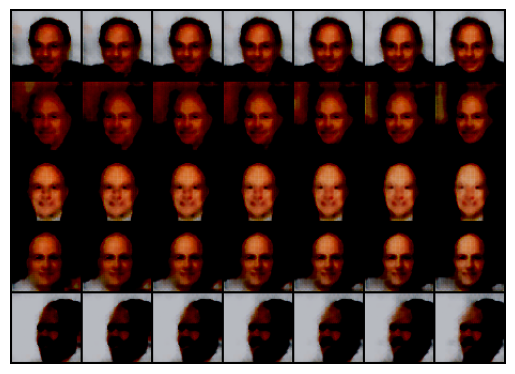

In [1]:
image_path = '/home/desai.ven/TCVAE/latent_celeba/latent_50_b_15_0.png'  # for Latent representation - 1
image = mpimg.imread(image_path)

plt.imshow(image)
plt.axis('off') 
plt.show()


## Result 

- The ELbo loss increasing to maximise the likelihood but visual results of the  for the baldness attributes were not same as obtained by the authors Figure 1, therefore I spent time to refine it and didn't work on other attributes of celeba dataset and chair dataset.

## Time Management for Task 1 and Task 2

- This week, I participated in a Kaggle Hackathon organized by the Data Science club. On Saturday, after receiving your email, I dedicated most of the day to reading the research paper related to the task 1, in which I gained a solid understanding of the TCVAE model.

- On Sunday (Day 2), I challenged myself to build the TCVAE model from scratch without referring to any existing code. Unfortunately, I was unable to successfully implement it as I encountered some difficulties along the way.

- Then, on Monday (Day 3), I decided to take a look at the code available on GitHub. I performed a dry run of the TCVAE model using the dSprites dataset, and although I encountered a few errors initially, I managed to resolve them and obtained satisfactory results. Afterwards, I proceeded to work with the CelebA dataset, but to my surprise, there were issues with loading the data on Google Colab. Fortunately, I still had access to the Northeastern cluster, which I obtained during my CS7150 course. Consequently, I had to set up all the required packages within a fresh virtual environment.

- Tuesday (Day 4) was a break from Task 1 as I shifted my focus to Task 2. During this time, I extensively explored various clustering algorithms and came across two particularly interesting papers, which I discussed in my Task 2 submission.

- On Wednesday (Day 5), I returned to Task 1 and began coding the necessary components by referring to the relevant files on GitHub. However, the results obtained from my first dataset fell short of expectations. Consequently, I spent a significant amount of time fine-tuning the hyperparameters and the model itself. Despite my efforts, I couldn't find a satisfactory solution. As a result, I made the decision to skip training the other attributes in the CelebA and chair datasets.

## Task 2

- The first approach that struck me, when I read the word clustering was k-means clustering method. Since I have spent some resonable time implementing K-means clustering I understand it is not that computationally expensive, simple to implement, the cluster centroids can provide insights into the visual patterns or some dominant features within each cluster. K-means have shown some promising results when it come to image segmentation tasks but there are a few drawbacks associated with this algorithm for our problem statement we are trying to solve like it understands that clusters are mostly to be a convex and have a spherical shape (which may not be true as image can have complex structures, textures, and shapes) therefore it would struggle to capture irregular shaped clusters; it also struggles to caputure clusters with overlapping regions; the algorithm dosen't gurantee to find a global optimum solution since it's highly sensitive to initial choice of cluster centroid, lack of robustness to outliers, Images can have a high dimensional feature representation which is the biggest drwaback for k-means as it would not perform that great in high dimension. 

Realizing these drawbacks I looked out for a few more papers who could cluster images with no true labels and I cam across two interesting papers
1. "Unsupervised Deep Embedding for Clustering Analysis"
2. "Variational Deep Embedding: An Unsupervised and Generative Approach to Clustering"

## 1. Unsupervised Deep Embedding for Clustering Analysis

- This paper introduce a approach called Deep Embedded Clustering (DEC) for unsupervised clustering using deep neural networks. This framework jointly learns feature representations and cluster assignments to improve the clustering performance.
- Instead of clustering directly in the data space X, DEC framework first transforms the data with a nonlinear mapping function f to latent feature space Z. The dimensionality of Z is typically much smaller than X enabling clustering algorithms like k-means to produce good results.
- This framework first trains on a Multilayer Deep Autoencoder by minimizing th ereconstruction loss. It has a bottleneck layer in the middle which is the latent feature space.
- Then, the decoder layer is discarded and only encoder layer is used to map data pace and feature space.
- Then, to initialize the cluster centers, the framework pass the data through the initialized DNN to get embedded data points and then perform standard k-means clustering in the feature space Z to obtain k initial centroids
- Inshort, DEC has two phases: (1) parameter initialization with a deep autoencoder and (2) parameter optimization (i.e., clustering), where the algorithm iterate between computing an auxiliary target distribution and minimizing the Kullback–Leibler (KL) divergence
- They define two metrics for evaluating clustering results with different cluster number: 
    - (1) Normalized Mutual Information (NMI), which measures the mutual information between the predicted clusters and the ground truth labels, normalized by the entropy of the clusters and labels.
    - (2) generalizability which is defined as the ratio between training and validation loss

### Validation
- The authors have compared DEC with outher clustering algorithms using benchmark datasets like MNIST, STL-HOG image datasets.
- The comparisson is based on clustering accuracy (Clustering accuracy measures the agreement between the predicted cluster assignments and the ground truth labels)
- The other clustering algorithms are k-means, LDMGI, SEC, and combination of Auto-encoders with k-means, LDMGI, SEC.
- Deep Embedding Clustering out performs all the above algorithm for all the datasets.

My suggestions-
1. train using VAE than AE because VAE explicitly models the prior distribution of the latent space. This allows the VAE to learn latent space representations that are more regularized and less likely to be overfit to the training data but it would also be computationaly expensive.


## 2. Variational Deep Embedding: An Unsupervised and Generative Approach to Clustering

- This paper proposes a unsupervised generative clustering approach within the framework of Variational Autoencoder (VAE) called Variational Deep Embedding(VaDE). This approach models the data generative process with a Gaussian Mixture Model (GMM) and a deep neural network (DNN).
- VaDE models the data generative process by a GMM and a DNN: 1) a cluster is picked up by the GMM; 2) from which a latent representation z is sampled; 3) DNN f decodes z to an observation x. 
- Moreover, VaDE is optimized by using another DNN g to encode observed data x into latent embedding z, so that the Stochastic Gradient Variational Bayes (SGVB) estimator and the reparameterization trick  can be used to maximize the evidence lower bound (ELBO). 
- VaDE generalizes VAE in that a Mixture-of-Gaussians prior replaces the single Gaussian prior. Hence, VaDE is by design more suitable for clustering tasks.
- The authors also discuss a case wherein If the number of clusters is larger than the number of classes, what would happen? In this case some digits will fall into sub-classes by VaDE, such as the fatter 0 and thinner 0, and the upright 1 and oblique 1 fr MNIST dataset.

### Validation
- The authors have compared DEC with outher clustering algorithms using benchmark datasets like MNIST, STL-10 image datasets.
- The comparisson is based on clustering accuracy (Clustering accuracy measures the agreement between the predicted cluster assignments and the ground truth labels)
- The other clustering algorithms are LDMGI, AAE, DEC, GMM, combination of GMM with Auto-encoders, Variational Auto-encoders.
- Variational Deep Embedding out performs all the above algorithm for all the datasets with a good margin.


My Insights:-

- After understanding these two frameworks, both the frameworks may not be that fast as compared to k-means algorithms, but they are scalable, their latent representations can extract meaningful learning and can also handle high dimension features.

- I believe if VAE was used instead of Multilayer Autencoders in Deep Embedding Clusters(DEC) because VAE explicitly models the prior distribution of the latent space. This allows the VAE to learn latent space representations that are more regularized.

- Therefore, I believe for our task VaDE model would be better because it is generative model using VAE, therefore it would encourage the latent space to have meaningful and disentangled representations. By imposing specific prior distributions on the latent space, VAEs can learn to capture and separate relevant factors of variation in the data, which can correspond to semantic information. This disentanglement can lead to more interpretable and semantically meaningful latent representations.


- We could try using different probabilistic models that might give better results on our dataset. 

- Looking at the dataset I feel the latent representations could learn to:-
    - Capture visual cues or indicators related to political bias or ideology - like clothing choices, symbols, or visual elements associated with a particular political party
    - might encode information about visual themes commonly associated with each political group like images related to specific political issues, campaign materials, political rallies, or prominent political figures.
    - might capture demographic or socioeconomic characteristics - like age, gender, ethnicity
    -contextual information like political events, protests, policy discussions
    - might also capture individual or group-level visual styles or aesthetic preferences in terms of image composition, color palettes, or image filters that are commonly associated with Democrats or Republicans

